In [40]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [4]:
with open('train_qa.txt', 'rb') as fp:
    train_data = pickle.load(fp)
    fp.close()
with open('test_qa.txt', 'rb') as fp:
    test_data = pickle.load(fp)
    fp.close()

In [16]:
questions = []
sentences = []
answers = []
for sentence, question, answer in train_data:
    questions.append(question)
    sentences.append(sentence)
    answers.append(answer)
df = pd.DataFrame({
    'sentences': sentences, 
    'questions': questions, 
    'answers': answers
})

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['sentences'])
tokenizer.fit_on_texts(df['questions'])
tokenizer.fit_on_texts(df['answers'])

In [30]:
vocab_size = len(tokenizer.word_index)

In [31]:
questions = []
sentences = []
answers = []
for sentence, question, answer in test_data:
    questions.append(question)
    sentences.append(sentence)
    answers.append(answer)
test_df = pd.DataFrame({
    'sentences': sentences, 
    'questions': questions, 
    'answers': answers
})

In [58]:
max_sentence_len = max([len(item) for item in df['sentences'].tolist()] + 
                       [len(item) for item in test_df['sentences'].tolist()])

max_question_len = max([len(item) for item in df['questions'].tolist()] + 
                       [len(item) for item in test_df['questions'].tolist()])

In [59]:
print('max sentence length: {}'.format(max_sentence_len))
print('max question length: {}'.format(max_question_len))

max sentence length: 156
max question length: 6


In [141]:
sentences_tokens = df['sentences'].apply(lambda x: [tokenizer.word_index[word.lower()] for word in x])
test_sentences_tokens = test_df['sentences'].apply(lambda x: [tokenizer.word_index[word.lower()] for word in x])
questions_tokens = df['questions'].apply(lambda x: [tokenizer.word_index[word.lower()] for word in x])
test_questions_tokens = test_df['questions'].apply(lambda x: [tokenizer.word_index[word.lower()] for word in x])

In [142]:
padded_sentences = pad_sequences(sentences_tokens, maxlen = max_sentence_len, padding='post')
test_padded_sentences = pad_sequences(test_sentences_tokens, maxlen = max_sentence_len, padding='post')
padded_questions = pad_sequences(questions_tokens, maxlen = max_question_len, padding='post')
test_padded_questions = pad_sequences(test_questions_tokens, maxlen = max_question_len, padding='post')

In [143]:
padded_sentences.shape, padded_questions.shape

((10000, 156), (10000, 6))

In [190]:
test_padded_sentences.shape, test_padded_questions.shape

((1000, 156), (1000, 6))

In [191]:
train_answers = pd.get_dummies(df['answers'])
test_answers = pd.get_dummies(test_df['answers'])

In [192]:
train_answers.shape

(10000, 2)

In [193]:
test_answers.shape

(1000, 2)

In [308]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM, Multiply

In [309]:
input_sequence = Input((max_sentence_len,)) #As we dont know batch size yet
input_question = Input((max_question_len,))

In [310]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size + 1, output_dim = 64, input_length=max_sentence_len)) #From paper
input_encoder_m.add(Dropout(0.3))

In [311]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size + 1, output_dim = max_question_len, input_length=max_sentence_len)) #From paper
input_encoder_c.add(Dropout(0.3))

In [312]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size + 1, output_dim = 64, input_length=max_question_len)) #From paper
question_encoder.add(Dropout(0.3))

In [313]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(input_question)

In [314]:
input_encoded_m.shape, input_encoded_c.shape, question_encoded.shape

(TensorShape([None, 156, 64]),
 TensorShape([None, 156, 6]),
 TensorShape([None, 6, 64]))

In [315]:
match = dot([input_encoded_m, question_encoded], axes = (2,2))
match = Activation('softmax')(match)

In [319]:
response = Multiply()([match, input_encoded_c])
response = Permute((2,1))(response) #Permute Layer: permutes dimensions of input

In [320]:
response.shape

TensorShape([None, 6, 156])

In [321]:
answer = concatenate([response, question_encoded])

In [322]:
answer.shape

TensorShape([None, 6, 220])

In [323]:
answer = LSTM(32)(answer)

In [324]:
answer = Dropout(0.5)(answer)

In [325]:
answer = Dense(2)(answer) #Output shape: (Samples, Vocab_size) #Yes or no and all 0s

In [326]:
answer = Activation('softmax')(answer)

In [327]:
model = Model([input_sequence, input_question], answer)

In [328]:
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [329]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential_21 (Sequential)      (None, 156, 64)      2432        input_18[0][0]                   
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 6, 64)        2432        input_19[0][0]                   
____________________________________________________________________________________________

In [330]:
history = model.fit(
    [
     padded_sentences,
     padded_questions
    ],
    train_answers, 
    batch_size = 32, 
    epochs = 100, 
    validation_data = ([test_padded_sentences, test_padded_questions], test_answers)
    )

Epoch 1/100
313/313 [==============================] - 7s 16ms/step - loss: 0.6940 - accuracy: 0.4777 - val_loss: 0.6937 - val_accuracy: 0.5030
Epoch 2/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6936 - accuracy: 0.5020 - val_loss: 0.6942 - val_accuracy: 0.5030
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6935 - accuracy: 0.5012 - val_loss: 0.6943 - val_accuracy: 0.5060
Epoch 4/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6924 - accuracy: 0.5231 - val_loss: 0.6945 - val_accuracy: 0.5040
Epoch 5/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6923 - accuracy: 0.5127 - val_loss: 0.6946 - val_accuracy: 0.4850
Epoch 6/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6923 - accuracy: 0.5104 - val_loss: 0.6952 - val_accuracy: 0.4800
Epoch 7/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6911 - accuracy: 0.5239 - val_loss: 0.6945 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


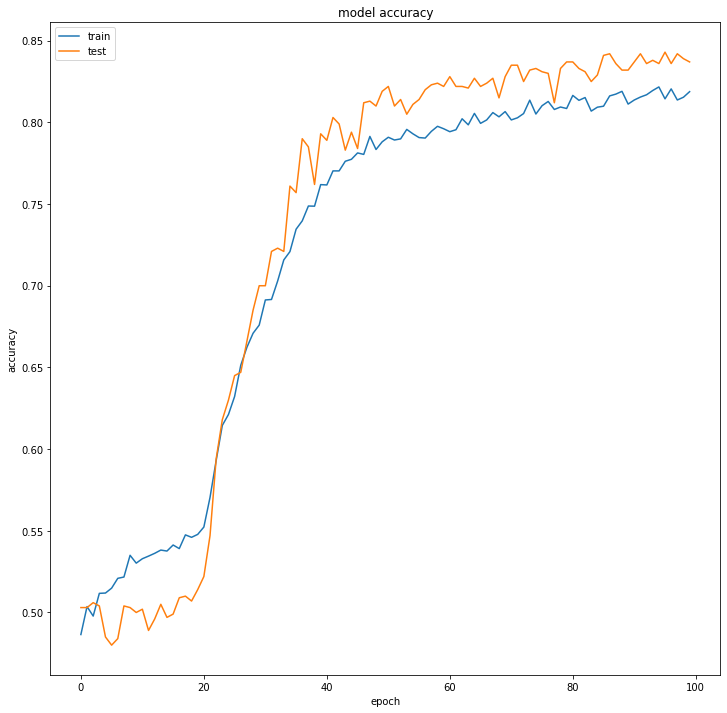

In [331]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(12,12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [219]:
test_data[0]

(['Mary',
  'got',
  'the',
  'milk',
  'there',
  '.',
  'John',
  'moved',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'John', 'in', 'the', 'kitchen', '?'],
 'no')

In [222]:
results = model.predict([test_padded_sentences, test_padded_questions])

In [225]:
np.argmax(results[0])

0

In [227]:
np.argmax(results[1])

0

In [228]:
np.argmax(results[2])

1